In [1]:
import os, shutil, random, pickle
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from skimage.util import img_as_ubyte

from scipy.optimize import curve_fit
from scipy import stats

In [2]:
# === 输入：一个 position 的 PreprocessedPhase 文件夹 ===
# INPUT_DIR = r"./data/REF_masks101_110/REF_masks101_110/Pos101/PreprocessedPhaseMasks/"  # 改成你的真实路径
INPUT_DIR = r"./data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase"  # 改成你的真实路径
IMAGE_EXT = ".tiff"  # ".tif" or ".tiff"

# === 输出目录（保存 mask & 面积 pickle）===
SAVE_DIR = os.path.join(INPUT_DIR, "Masks_OMNI")
os.makedirs(SAVE_DIR, exist_ok=True)

# === 成像参数（跟你原 notebook 一样）===
INTERVAL_MIN = 2  # 每帧 2 min
PIXEL_SIZE_UM = 0.0733  # 73.3 nm -> 0.0733 um
PIXEL_AREA = PIXEL_SIZE_UM ** 2

# === 分割参数（先按你原来的）===
FLOW_THRESHOLD = 0.8
CELLPROB_THRESHOLD = 0.0
MIN_SIZE = 250
DIAMETER = None  # None 表示自动估计。你也可以设置 40 之类


Found images: 121
First file: img_000000000.tiff
Loaded 121 images.
Example shape: (782, 499)
Showing: img_000000004


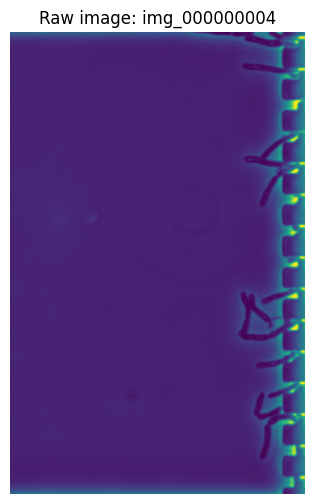

In [3]:
files = sorted([
    os.path.join(INPUT_DIR, f)
    for f in os.listdir(INPUT_DIR)
    if f.lower().endswith(IMAGE_EXT)
])

print("Found images:", len(files))
print("First file:", os.path.basename(files[0]) if files else "None")

imgs = []
for f in files:
    im = skimage.io.imread(f)
    # 如果是 (C,H,W) -> (H,W,C)
    if im.ndim == 3 and im.shape[0] <= 4 and im.shape[0] < min(im.shape[1], im.shape[2]):
        im = im.transpose(1, 2, 0)
    imgs.append(im)

print("Loaded", len(imgs), "images.")
print("Example shape:", imgs[0].shape if imgs else None)

# 展示随机一帧
idx = random.randrange(len(imgs))
img0 = imgs[idx]
name0 = os.path.splitext(os.path.basename(files[idx]))[0]
print("Showing:", name0)

plt.figure(figsize=(6, 6), facecolor="white")
if img0.ndim == 2:
    plt.imshow(img0)
else:
    # 多通道就先显示第0通道
    plt.imshow(img0[..., 0])
plt.axis("off")
plt.title(f"Raw image: {name0}")
plt.show()


In [4]:
import cellpose_omni
import inspect
from cellpose_omni import models

print(cellpose_omni.__file__)
print(models.__file__)
print(inspect.signature(models.Cellpose))

D:\Codes\Python\RM\.venv\Lib\site-packages\cellpose_omni\__init__.py
D:\Codes\Python\RM\.venv\Lib\site-packages\cellpose_omni\models.py
(gpu=False, model_type='cyto', net_avg=True, device=None, use_torch=True, model_dir=None, dim=2, omni=None)


In [5]:
from cellpose_omni import models, core
use_GPU = core.use_gpu()

model = models.CellposeModel(
    gpu=use_GPU,
    pretrained_model="bact_phase_omni",
    model_type="bact_phase_omni",
    nchan=1,
    nclasses=3,
    dim=2,
    omni=True
)

2025-12-11 22:37:12,905 [INFO] ** TORCH GPU version installed and working. **
2025-12-11 22:37:12,906 [WARNING] pretrained model has incorrect path
2025-12-11 22:37:12,906 [INFO] >>bact_phase_omni<< model set to be used
2025-12-11 22:37:12,908 [INFO] ** TORCH GPU version installed and working. **
2025-12-11 22:37:12,908 [INFO] >>>> using GPU


2025-12-11 22:54:20,718 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
Instances: 36


C:\Users\Icey\AppData\Local\Temp\ipykernel_2364\2673071329.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("nipy_spectral").copy()


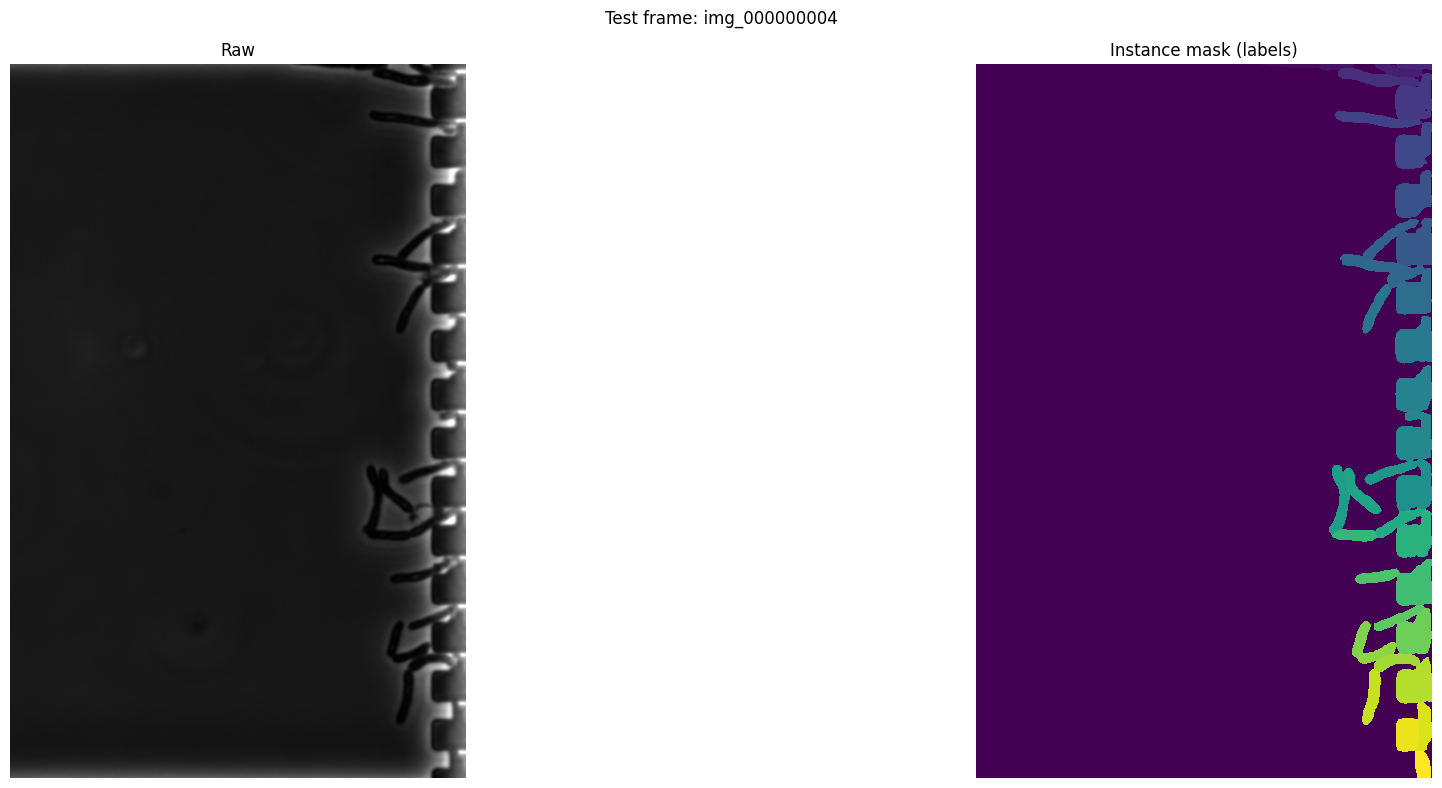

In [18]:
test_img = imgs[idx]
if test_img.ndim == 3:
    test_img_in = test_img[..., 0]
else:
    test_img_in = test_img

masks, flows, styles = model.eval(
    test_img_in,
    diameter=DIAMETER,
    channels=[0, 0],  # 单通道相位差
    omni=True,
    flow_threshold=FLOW_THRESHOLD,
    cellprob_threshold=CELLPROB_THRESHOLD,
    min_size=MIN_SIZE
)

print("Instances:", int(masks.max()))

# 可视化：原图 + mask（彩色label）
plt.figure(figsize=(24, 8), facecolor="white")

plt.subplot(1, 2, 1)
plt.imshow(test_img_in, cmap="gray")
plt.axis("off")
plt.title("Raw")

cmap = plt.cm.get_cmap("nipy_spectral").copy()
cmap.set_under("black")          # 小于 vmin 的颜色设为黑

plt.subplot(1, 2, 2)
plt.imshow(masks, interpolation="nearest")
plt.axis("off")
plt.title("Instance mask (labels)")

plt.suptitle(f"Test frame: {name0}")
plt.tight_layout()
plt.show()


In [20]:
# 如果你想每次重跑都清空旧 mask，可以打开下面两行
# if os.path.exists(SAVE_DIR):
#     shutil.rmtree(SAVE_DIR)
# os.makedirs(SAVE_DIR, exist_ok=True)

pos_areas_pixels = np.zeros(len(imgs), dtype=float)

for i, (img, path) in enumerate(zip(imgs, files)):
    base = os.path.splitext(os.path.basename(path))[0]
    print(f"[{i + 1}/{len(imgs)}] Segmenting {base}")

    if img.ndim == 3:
        img_in = img[..., 0]
    else:
        img_in = img

    masks, flows, styles = model.eval(
        img_in,
        diameter=DIAMETER,
        channels=[0, 0],
        omni=True,
        flow_threshold=FLOW_THRESHOLD,
        cellprob_threshold=CELLPROB_THRESHOLD,
        min_size=MIN_SIZE
    )

    labels = masks.astype(np.uint16)

    # area: 所有实例像素数总和（跳过背景0）
    counts = np.unique(labels, return_counts=True)[1][1:]
    pos_areas_pixels[i] = counts.sum()

    # 保存 mask（背景=0，实例=1,2,3...）
    out_mask = os.path.join(SAVE_DIR, f"MASK_{base}.tif")
    skimage.io.imsave(out_mask, labels, check_contrast=False)

# 保存 areas
with open(os.path.join(SAVE_DIR, "growth_areas.pickle"), "wb") as f:
    pickle.dump(pos_areas_pixels, f)

print("Saved masks to:", SAVE_DIR)
print("Saved growth_areas.pickle:", os.path.join(SAVE_DIR, "growth_areas.pickle"))
print("Area sample (pixels):", pos_areas_pixels[:10])


[1/121] Segmenting img_000000000
2025-12-11 23:04:12,935 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
[2/121] Segmenting img_000000001
2025-12-11 23:04:13,724 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
[3/121] Segmenting img_000000002
2025-12-11 23:04:14,377 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
[4/121] Segmenting img_000000003
2025-12-11 23:04:14,876 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
[5/121] Segmenting img_000000004
2025-12-11 23:04:15,321 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
[6/121] Segmenting img_000000005
2025-12-11 23:04:15,750 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a

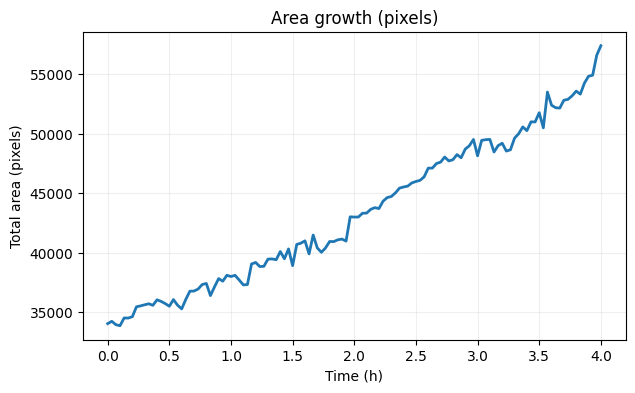

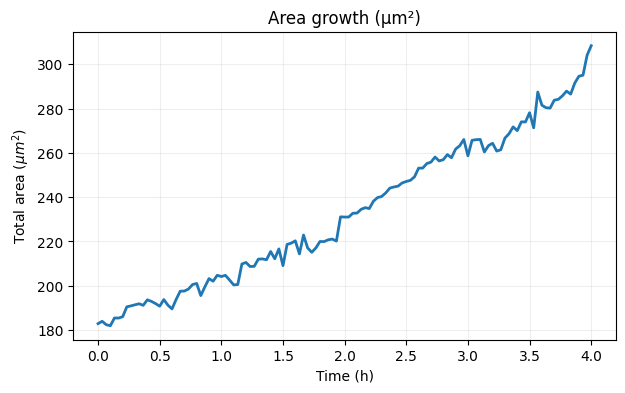

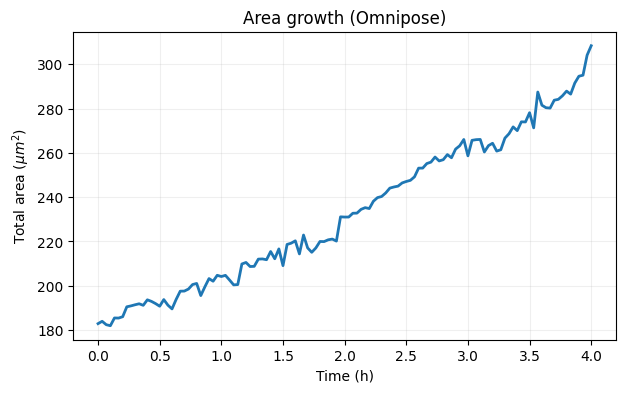

Saved: ./data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_OMNI\Area_growth_omni.svg


In [21]:
time_h = np.arange(len(pos_areas_pixels)) * (INTERVAL_MIN / 60.0)

pos_areas_um2 = pos_areas_pixels * PIXEL_AREA

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_h, pos_areas_pixels, lw=2)
plt.xlabel("Time (h)")
plt.ylabel("Total area (pixels)")
plt.title("Area growth (pixels)")
plt.grid(alpha=0.2)
plt.show()

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_h, pos_areas_um2, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Total area ($\mu m^2$)")
plt.title("Area growth (µm²)")
plt.grid(alpha=0.2)
plt.show()

# 保存图
plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_h, pos_areas_um2, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Total area ($\mu m^2$)")
plt.title("Area growth (Omnipose)")
plt.grid(alpha=0.2)
plt.savefig(os.path.join(SAVE_DIR, "Area_growth_omni.svg"), bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(SAVE_DIR, "Area_growth_omni.svg"))


Growth rate length: 105
Fits ok: 105 / 105
Example growth rates: [0.124225   0.12111813 0.10831679 0.08059217 0.06287118 0.06635733
 0.06425518 0.06212315 0.07862573 0.093703  ]


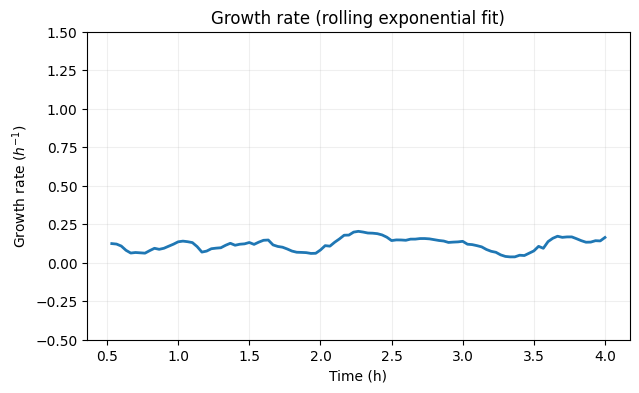

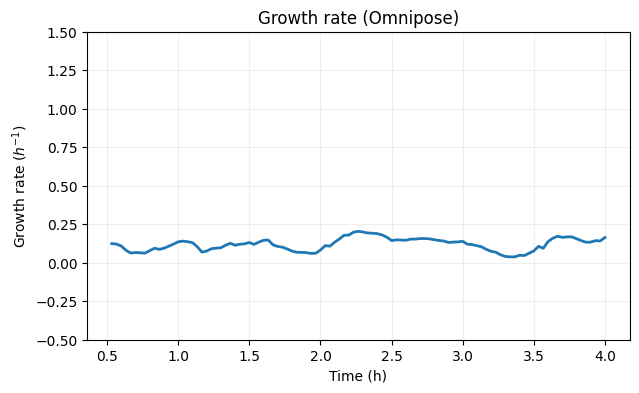

Saved: ./data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_OMNI\growth_rate_rolling.pickle
Saved: ./data/REF_raw_data101_110/REF_raw_data101_110/Pos101/aphase\Masks_OMNI\Growth_rate_omni.svg


In [22]:
def exp_growth_fit(x, a, b):
    return a * np.exp(b * x)


ROLLING_NUMBER = 16  # 你原来是 16（约 32min 窗口，如果 2min/帧）

areas = pos_areas_um2.copy()

growth_rates = []
fit_ok = 0

for i in range(ROLLING_NUMBER, len(areas)):
    x = np.arange(ROLLING_NUMBER)
    y = areas[i - ROLLING_NUMBER:i]

    # 避免非正值导致拟合怪异
    if np.any(y <= 0):
        growth_rates.append(np.nan)
        continue

    p0 = [y[0], 0.001]
    try:
        popt, _ = curve_fit(exp_growth_fit, x, y, p0=p0, maxfev=5000)
        b_per_frame = popt[1]
        b_per_hour = b_per_frame * (60.0 / INTERVAL_MIN)
        growth_rates.append(b_per_hour)
        fit_ok += 1
    except RuntimeError:
        growth_rates.append(np.nan)

growth_rates = np.array(growth_rates, dtype=float)

print("Growth rate length:", len(growth_rates))
print("Fits ok:", fit_ok, "/", len(growth_rates))
print("Example growth rates:", growth_rates[~np.isnan(growth_rates)][:10])

# 时间轴要对应到拟合窗口末端（或你也可以对齐到窗口中心）
time_gr_h = np.arange(ROLLING_NUMBER, len(areas)) * (INTERVAL_MIN / 60.0)

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_gr_h, growth_rates, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Growth rate ($h^{-1}$)")
plt.title("Growth rate (rolling exponential fit)")
plt.ylim(-0.5, 1.5)
plt.grid(alpha=0.2)
plt.show()

# 保存 growth rate 数组
with open(os.path.join(SAVE_DIR, "growth_rate_rolling.pickle"), "wb") as f:
    pickle.dump(growth_rates, f)

plt.figure(figsize=(7, 4), facecolor="white")
plt.plot(time_gr_h, growth_rates, lw=2)
plt.xlabel("Time (h)")
plt.ylabel(r"Growth rate ($h^{-1}$)")
plt.title("Growth rate (Omnipose)")
plt.ylim(-0.5, 1.5)
plt.grid(alpha=0.2)
plt.savefig(os.path.join(SAVE_DIR, "Growth_rate_omni.svg"), bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(SAVE_DIR, "growth_rate_rolling.pickle"))
print("Saved:", os.path.join(SAVE_DIR, "Growth_rate_omni.svg"))


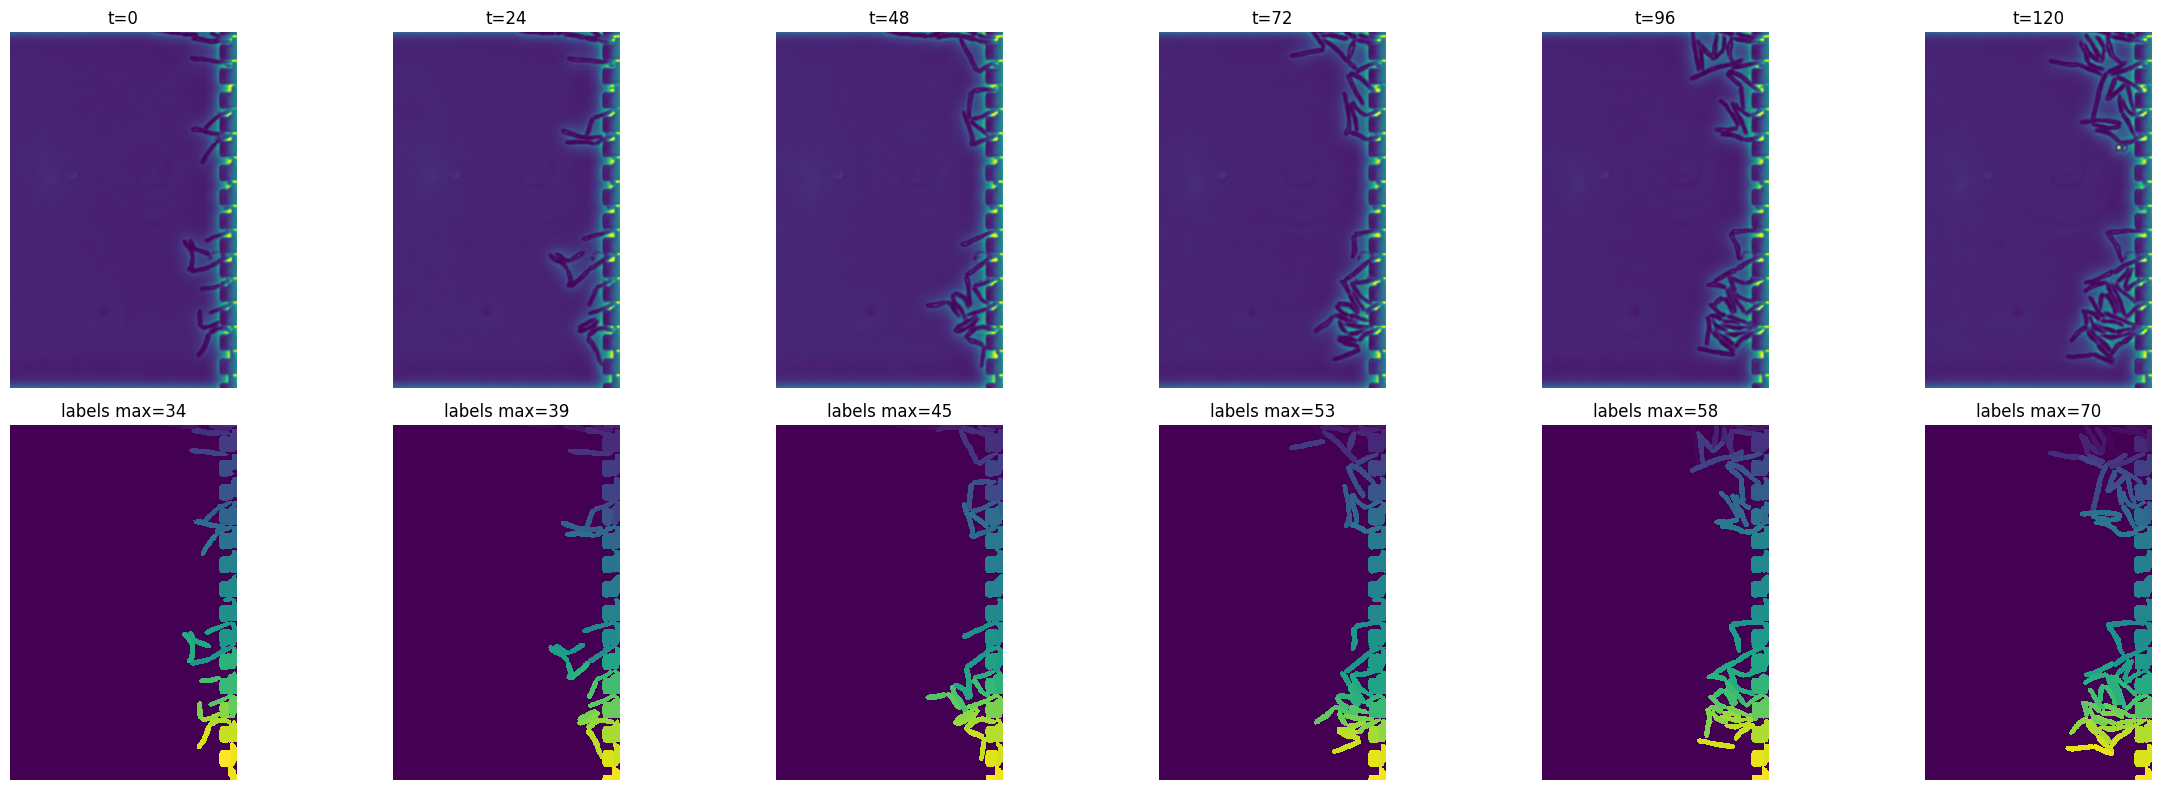

In [24]:
# 选 6 帧均匀抽样
n_show = 6
idxs = np.linspace(0, len(imgs) - 1, n_show).astype(int)

plt.figure(figsize=(24, 8), facecolor="white")

for k, i in enumerate(idxs):
    img = imgs[i]
    if img.ndim == 3:
        img_in = img[..., 0]
    else:
        img_in = img

    base = os.path.splitext(os.path.basename(files[i]))[0]
    mask_path = os.path.join(SAVE_DIR, f"MASK_{base}.tif")
    m = skimage.io.imread(mask_path)

    plt.subplot(2, n_show, k + 1)
    plt.imshow(img_in)
    plt.axis("off")
    plt.title(f"t={i}")

    plt.subplot(2, n_show, n_show + k + 1)
    plt.imshow(m, interpolation="nearest")
    plt.axis("off")
    plt.title(f"labels max={m.max()}")

plt.tight_layout()
plt.show()
